# Reproducing Real Covidi-19 data

In [46]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot

-------

## Set basic parameters

Set the total population size

In [47]:
N = 10000 

In [91]:
INIT_EXPOSED = 13 # March 15th : 11300/(8859000/10000)

In [92]:
demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
                                                            N=N, demographic_data=household_country_data('US'), 
                                                            distancing_scales=[0.7], isolation_groups=[])

G_baseline   = demographic_graphs['baseline']
G_quarantine = demographic_graphs['distancingScale0.7']

households_indices = [household['indices'] for household in households]

Generated overall age distribution:
0-9: 0.1070	(-0.0140 from target)
10-19: 0.1203	(-0.0107 from target)
20-29: 0.1344	(-0.0026 from target)
30-39: 0.1394	(0.0064 from target)
40-49: 0.1241	(0.0001 from target)
50-59: 0.1352	(0.0042 from target)
60-69: 0.1211	(0.0061 from target)
70-79: 0.0767	(0.0067 from target)
80+: 0.0418	(0.0038 from target)

Generated household size distribution:
1: 0.2851	(0.0014 from target)
2: 0.3355	(-0.0096 from target)
3: 0.1606	(0.0099 from target)
4: 0.1279	(0.0003 from target)
5: 0.0530	(-0.0047 from target)
6: 0.0238	(0.0012 from target)
7: 0.0140	(0.0015 from target)
Num households: 4072
mean household size: 2.448393594

Generating graph for 0-9...
Generating graph for 10-19...
Generating graph for 20-59...
Generating graph for 60+...


Baseline:
Degree: mean = 13.96, std = 13.36, 95% CI = (2.00, 52.00)
        coeff var = 0.96
Assortativity:    0.15
Clustering coeff: 0.26



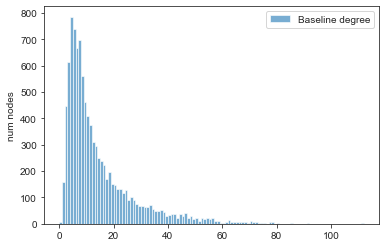

In [93]:
network_info(G_baseline, "Baseline", plot=True)

Quarantine:
Degree: mean = 2.30, std = 1.59, 95% CI = (0.00, 6.00)
        coeff var = 0.69
Assortativity:    0.95
Clustering coeff: 0.60



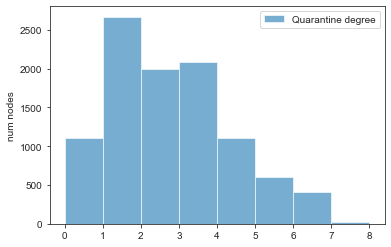

In [94]:
network_info(G_quarantine, "Quarantine", plot=True)

In [95]:
print(len(demographic_graphs))
print(len(individual_ageGroups))
print(len(households))

2
10000
4072


-------

## Specifying parameters

**_The parameter values used in this notebook reflect rough estimates of parameter values for the COVID-19 epidemic (as of 9 Aug 2020)._**

### Set disease progression rate parameters:

latent period:  mean = 2.20, std = 1.09, 95% CI = (0.60, 4.76)

pre-symptomatic period:  mean = 3.00, std = 1.79, 95% CI = (0.57, 7.42)

total incubation period:  mean = 5.20, std = 2.08, 95% CI = (1.98, 10.02)



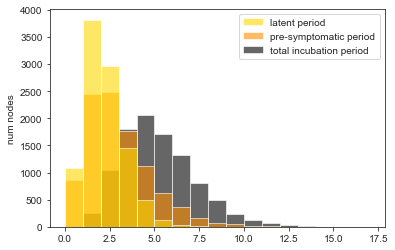

In [96]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

pre-symptomatic period:  mean = 2.20, std = 1.09, 95% CI = (0.60, 4.76)

(a)symptomatic period:  mean = 3.98, std = 1.61, 95% CI = (1.47, 7.64)

total infectious period:  mean = 6.18, std = 1.95, 95% CI = (3.01, 10.49)



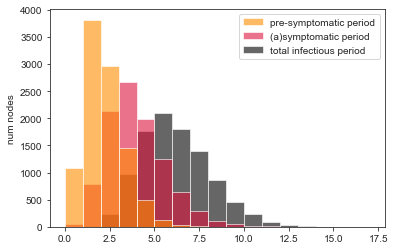

In [97]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

Generate a distribution of expected onset-to-hospitalization periods (time in symptomatic state before entering hospitalized state for those with severe cases) and hospitalization-to-discharge periods (time in hospitalized state for those with non-fatal cases). The `eta` and `gamma_H` rates are calculated as the inverse of the expected onset-to-hospitalization periods and hospitalization-to-discharge periods assigned to each individual, respectively.

onset-to-hospitalization period:  mean = 11.05, std = 4.93, 95% CI = (3.56, 22.53)

hospitalization-to-discharge period:  mean = 10.98, std = 4.92, 95% CI = (3.50, 22.63)

onset-to-discharge period:  mean = 22.03, std = 6.92, 95% CI = (10.64, 37.10)



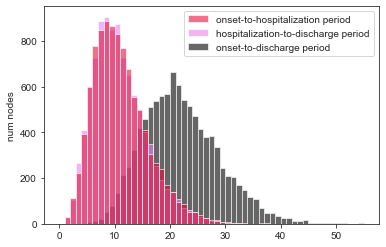

In [98]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

Generate a distribution of hospitalization-to-death periods (time in hospitalized state for those with fatal cases). The `mu_H` rates are calculated as the inverse of the expected hospitalization-to-death periods.

onset-to-hospitalization period:  mean = 11.05, std = 4.93, 95% CI = (3.56, 22.53)

hospitalization-to-death period:  mean = 6.98, std = 3.12, 95% CI = (2.30, 14.26)

onset-to-death period:  mean = 18.03, std = 5.87, 95% CI = (8.49, 31.43)



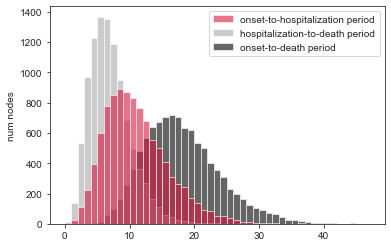

In [99]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

### Set severity parameters

Specify the percentage of cases that are asymptomatic. This percentage of case will progress from the pre-symptomatic state to the asymptomatic state, rather than to the symptomatic state.

In [100]:
PCT_ASYMPTOMATIC = 0.25

Here we age-stratify our definition of asymptomatic rate by setting the percent of asymptomatic cases for children to be 80% while the rest of the adult population remains set at 25%.

The `individual_ageGroups` variable is returned by the [`generate_demographic_contact_network()` function](https://github.com/ryansmcgee/seirsplus/wiki/Network-generation#demographic-community-network) and holds a list of the age group labels assigned to each individual. This is useful for assigning parameters in an age-group-dependent way as we do for the following severity parameters.

In [101]:
PCT_ASYMPTOMATIC = [0.8 if age in ['0-9', '10-19'] else PCT_ASYMPTOMATIC for age in individual_ageGroups]

Here we specify age-stratified case hospitalization rates using rates taken from [Verity et al. (2020)](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext).

In [102]:
ageGroup_pctHospitalized = {'0-9':      0.0000,
                            '10-19':    0.0004,
                            '20-29':    0.0104,
                            '30-39':    0.0343,
                            '40-49':    0.0425,
                            '50-59':    0.0816,
                            '60-69':    0.118,
                            '70-79':    0.166,
                            '80+':      0.184 }
PCT_HOSPITALIZED = [ageGroup_pctHospitalized[ageGroup] for ageGroup in individual_ageGroups]

Here we specify fatality rates for hospitalized cases, again using rates taken from [Verity et al. (2020)](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext).

In [103]:
ageGroup_hospitalFatalityRate = {'0-9':     0.0000,
                                 '10-19':   0.3627,
                                 '20-29':   0.0577,
                                 '30-39':   0.0426,
                                 '40-49':   0.0694,
                                 '50-59':   0.1532,
                                 '60-69':   0.3381,
                                 '70-79':   0.5187,
                                 '80+':     0.7283 }
PCT_FATALITY = [ageGroup_hospitalFatalityRate[ageGroup] for ageGroup in individual_ageGroups]

### Set transmission parameters

Individual R0:  mean = 2.51, std = 0.50, 95% CI = (1.63, 3.58)



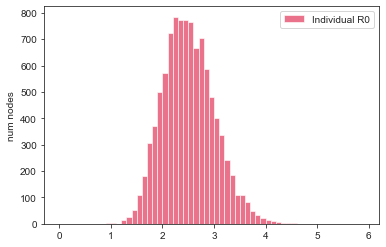

In [104]:
R0_mean     = 2.5
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, N)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

Individuals are ultimately assigned an [*Individual Transmissibility Value*](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#transmissibility-parameters) (*β<sup>i</sup>*), which are stored in the `beta` attribute of the model object. 

The means of the Individual Transmissibility Values for infectious subpopulations are used to calculate the [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) terms. Individual Transmissibility Values may also be used to generate the Pairwise Transmissibility Values used for [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission) terms, as we will specify in a few steps.

In [105]:
BETA = 1/infectiousPeriod * R0

Individuals can be assigned different Individual Transmissibility Values for use when they are asymptomatic and quarantine states. 

Here we set the transmissibility of quarantined individuals such that the mean effective reproduction number for quarantined individuals is about 0.3. This supposes that individuals have different behavior, hygiene, etc. when they are quarantining relative to baseline.

In [106]:
BETA_Q = BETA * (0.3/R0_mean)

Now we specify how we would like the [*Pairwise Transmissibility Values*](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#transmissibility-parameters) (*β<sup>i</sup>*), which define the local transmissibility for each pair of close contacts, to be calculated. There are [multiple ways to specify these pairwise transmissibilities](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#pairwise-transmissibility-values) (such as providing a matrix), but here we will set the `beta_pairwise_mode` argument of the `ExtSEIRSNetworkModel` constructor to `'infected'`, which will direct the model to automatically generate a matrix of Pairwise Transmissibility Values such that the transmissibility of each infectious-susceptible interaction is equal to the infected individual's transmissiblity.

In [107]:
BETA_PAIRWISE_MODE  = 'infected'

Here we designate that we would like the model to automatically calculate [Connectivity Correction Factors](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#connectivity-correction-factor) for each pair of interacting close contacts. This pairwise factor is optional, but it can be used to weight the transmissibility of interactions according to the connectivity of the interacting individuals. Here we choose to weight interactions according to a ratio of the pair's mean degree to the population's mean degree (see [Specifying connectivity Correction Factors](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#connectivity-correction-factors) for more information). 

Using this definition, when two individuals whose average degree is an order of magnitude greater than the average degree of the population overall, then the propensity of exposure in their interaction is weighted to be twice that of two averagely-connected individuals. 

In [108]:
DELTA_PAIRWISE_MODE = 'mean'

Here we set individual susceptibilities (default susceptibility is 1). 

In particular, we specify that children are half as susceptible as adults.

In [109]:
ALPHA = [0.5 if age in ['0-9', '10-19'] else 1.0 for age in individual_ageGroups]

In the stochastic network model, an individual comes into contact with a random individual from the population at large (e.g., in a public space) with probability *p* or with an individual from their set of close contacts with probability *(1-p)*. Transmission that occurs between an individual and the population at large is referred to as [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission), and transmission between an individual and one of their close contacts (network neighbors) is referred to as [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission). The parameter *p* defines the locality of the network: for *p=0* an individual only interacts with their close contacts, while *p=1* represents a uniformly mixed population.

Here we set *p* to reflect 20% of interactions being with incidental or casual contacts outside their set of close contacts.

In [110]:
P_GLOBALINTXN = 0.2

The parameter *q* (down)weights the rate of interactions with the population at large while one is in quarantine relative to baseline.

Here we set *q* to 0.05, which supposes that global interactions are quite rare (but nonzero) for quarantined individuals.

In [111]:
Q_GLOBALINTXN = 0.05

### Set Testing, Tracing, & Isolation (TTI) intervention protocol parameters:

Here we specify the parameters that govern the Testing, Tracing, and Isolation protocol that is implemented by the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop). The implementation of this TTI protocol and the interpretation of these parameters is desribed in detail on the [TTI Simulation Loop wiki page](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop) (but these parameters are briefly explained as code comments below).

In [112]:
INTERVENTION_START_PCT_INFECTED = 1/100
AVERAGE_INTRODUCTIONS_PER_DAY   = 0

TESTING_CADENCE                 = 'everyday'    # how often to do tracing testing and random testing
PCT_TESTED_PER_DAY              = 1/10          # max daily test allotment defined as a percent of population size
TEST_FALSENEG_RATE              = 'temporal'    # test false negative rate, will use FN rate that varies with disease time
MAX_PCT_TESTS_FOR_SYMPTOMATICS  = 1.0           # max percent of daily test allotment to use on self-reporting symptomatics
MAX_PCT_TESTS_FOR_TRACES        = 1.0           # max percent of daily test allotment to use on contact traces
RANDOM_TESTING_DEGREE_BIAS      = 0             # magnitude of degree bias in random selections for testing, none here

PCT_CONTACTS_TO_TRACE           = 0.5           # percentage of primary cases' contacts that are traced
TRACING_LAG                     = 2             # number of cadence testing days between primary tests and tracing tests

ISOLATION_LAG_SYMPTOMATIC       = 1             # number of days between onset of symptoms and self-isolation of symptomatics
ISOLATION_LAG_POSITIVE          = 2             # test turn-around time (TAT): number of days between administration of test and isolation of positive cases
ISOLATION_LAG_CONTACT           = 0             # number of days between a contact being traced and that contact self-isolating


### Set intervention compliance parameters

First, we specify the compliance rates (i.e., the percentage of individuals who are compliant) for each intervention type. See the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop) documentation for more information about compliance.

In [113]:
TESTING_COMPLIANCE_RATE_SYMPTOMATIC                  = 0.5
TESTING_COMPLIANCE_RATE_TRACED                       = 1.0
TESTING_COMPLIANCE_RATE_RANDOM                       = 0.8

TRACING_COMPLIANCE_RATE                              = 0.8

ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL     = 0.3
ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE      = 0.0
ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL        = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE         = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT           = 0.8
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE  = 0.0

Now, we randomly assign a `True/False` compliance to each individual according to the rates set above. Individuals whose compliance is set to `True` for a given intervention will participate in that intervention, individuals set to `False` will not.

In [114]:
TESTING_COMPLIANCE_RANDOM                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_RANDOM)
TESTING_COMPLIANCE_TRACED                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_TRACED)
TESTING_COMPLIANCE_SYMPTOMATIC                   = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_SYMPTOMATIC)

TRACING_COMPLIANCE                               = (numpy.random.rand(N) < TRACING_COMPLIANCE_RATE)

ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL      = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL)
ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE       = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL         = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL)
ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE          = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_CONTACT            = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT)
ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE   = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE)

-------

## Initializing the model

In [115]:
model = ExtSEIRSNetworkModel(G=G_baseline, p=P_GLOBALINTXN,
                              beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                              gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                              a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                              alpha=ALPHA, beta_pairwise_mode=BETA_PAIRWISE_MODE, delta_pairwise_mode=DELTA_PAIRWISE_MODE,
                              G_Q=G_quarantine, q=0, beta_Q=BETA_Q, isolation_time=14,
                              initE=INIT_EXPOSED)

-------

## Running the model

Set the max simulation time to 300 days.

In [133]:
T = 60

Execute the TTI simulation scenario by calling the `run_tti_sim()` function, which runs a custom simulation loop that implements the [TTI Simulation Protocol](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop).

In [134]:
run_tti_sim(model, T, 
            intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED, average_introductions_per_day=AVERAGE_INTRODUCTIONS_PER_DAY,
            testing_cadence=TESTING_CADENCE, pct_tested_per_day=PCT_TESTED_PER_DAY, test_falseneg_rate=TEST_FALSENEG_RATE, 
            testing_compliance_symptomatic=TESTING_COMPLIANCE_SYMPTOMATIC, max_pct_tests_for_symptomatics=MAX_PCT_TESTS_FOR_SYMPTOMATICS,
            testing_compliance_traced=TESTING_COMPLIANCE_TRACED, max_pct_tests_for_traces=MAX_PCT_TESTS_FOR_TRACES,
            testing_compliance_random=TESTING_COMPLIANCE_RANDOM, random_testing_degree_bias=RANDOM_TESTING_DEGREE_BIAS,
            tracing_compliance=TRACING_COMPLIANCE, pct_contacts_to_trace=PCT_CONTACTS_TO_TRACE, tracing_lag=TRACING_LAG,
            isolation_compliance_symptomatic_individual=ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL, isolation_compliance_symptomatic_groupmate=ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE, 
            isolation_compliance_positive_individual=ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL, isolation_compliance_positive_groupmate=ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE,
            isolation_compliance_positive_contact=ISOLATION_COMPLIANCE_POSITIVE_CONTACT, isolation_compliance_positive_contactgroupmate=ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE,
            isolation_lag_symptomatic=ISOLATION_LAG_SYMPTOMATIC, isolation_lag_positive=ISOLATION_LAG_POSITIVE, isolation_groups=households_indices)

[INTERVENTIONS @ t = 30.01 (305 (3.05%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	1000	tested randomly         [+ 9 positive (0.90 %) +]
	1000	tested TOTAL            [+ 9 positive (0.90 %) +]
	6 will isolate due to symptoms         (0 as groupmates of symptomatic)
	9 will isolate due to positive test    (12 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 31.00 (310 (3.10%) infected)]
	6	tested due to symptoms  [+ 4 positive (66.67 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	994	tested randomly         [+ 12 positive (1.21 %) +]
	1000	tested TOTAL            [+ 16 positive (1.60 %) +]
	10 will isolate due to symptoms         (0 as groupmates of symptomatic)
	16 will isolate due to positive test    (30 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	6 entered 

(30.014282845602406, 60.01301583551319)

In [135]:
results_summary(model)

total percent infected: 17.35%
total percent fatality: 0.12%
peak  pct hospitalized: 0.18%


-------

## Visualizing the results

C:\ProgramData\Anaconda\lib\site-packages\seirsplus\models.py:3091: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


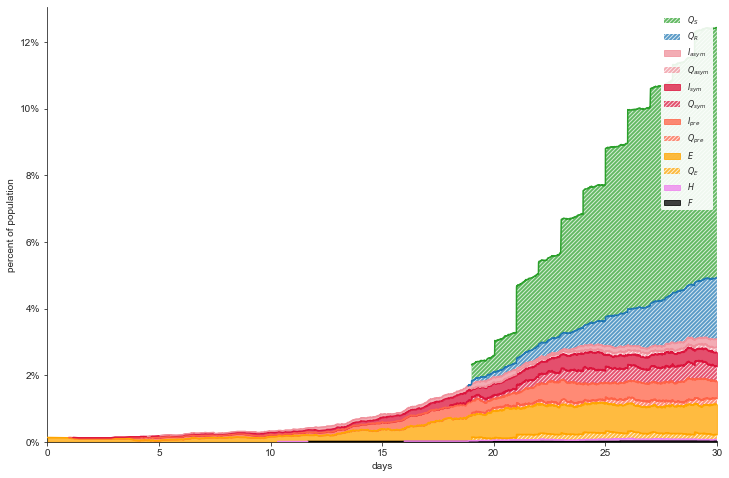

In [119]:
fig, ax = model.figure_infections(combine_Q_infected=False, plot_Q_R='stacked', plot_Q_S='stacked')

In [120]:
I_pre = model.numI_pre    # time series of I_pre counts
I_sym = model.numI_sym    # time series of I_sym counts
I_asym = model.numI_asym 

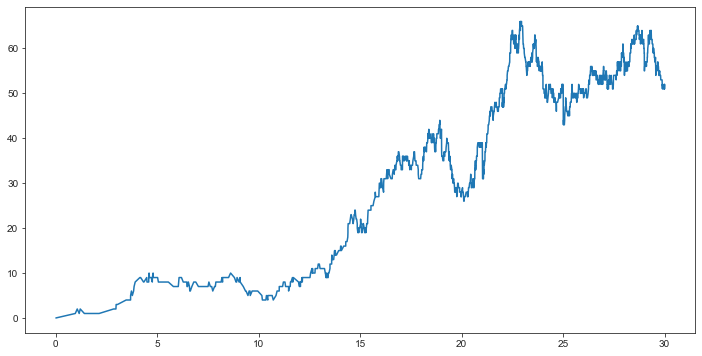

In [121]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(model.tseries, I_pre)

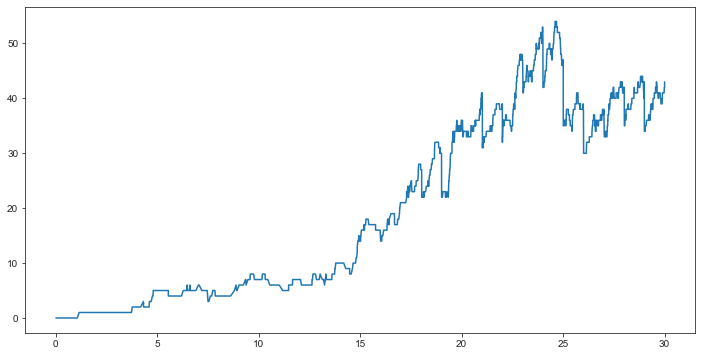

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(model.tseries, I_sym)

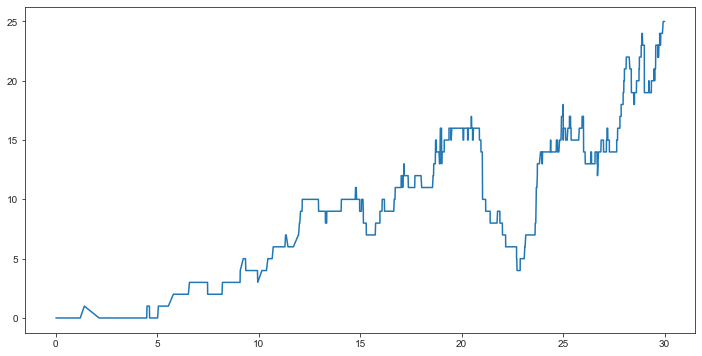

In [123]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(model.tseries, I_asym)

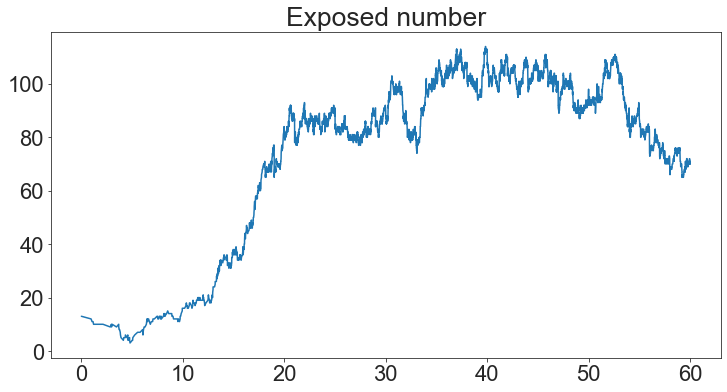

In [136]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,6))
plt.title("Exposed number")
plt.plot(model.tseries, model.numE)

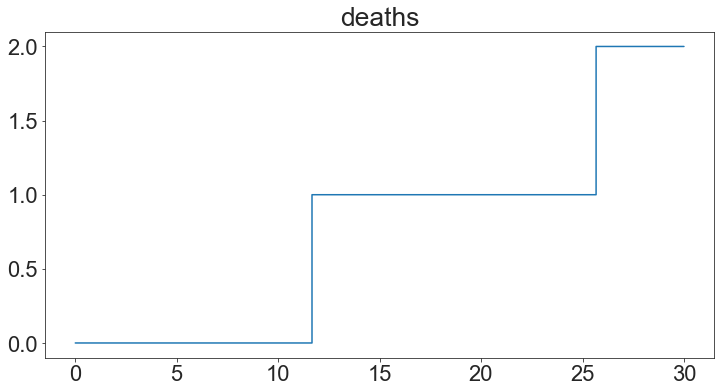

In [129]:
plt.figure(figsize=(12,6))
plt.title("deaths")
plt.plot(model.tseries, model.numF)